In [6]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data_dir = '../challenge_data/'

# read csv
X_train = pd.read_csv(data_dir + 'X_train.csv')
Y_train = pd.read_csv(data_dir + 'Y_train.csv')
X_test = pd.read_csv(data_dir + 'X_test.csv')

In [8]:
X_train.head().T

,0,1,2,3,4
ID,1054,2049,1924,297,1101
DAY_ID,206,501,687,720,818
COUNTRY,FR,FR,FR,DE,FR
DE_CONSUMPTION,0.210099,-0.022399,1.395035,-0.983324,0.143807
FR_CONSUMPTION,-0.427458,-1.003452,1.978665,-0.849198,-0.617038
DE_FR_EXCHANGE,-0.606523,-0.022063,1.021305,-0.839586,-0.92499
FR_DE_EXCHANGE,0.606523,0.022063,-1.021305,0.839586,0.92499
DE_NET_EXPORT,NaN,-0.57352,-0.622021,-0.27087,NaN
FR_NET_EXPORT,0.69286,-1.130838,-1.682587,0.56323,0.990324
DE_NET_IMPORT,NaN,0.57352,0.622021,0.27087,NaN


In [9]:
print('X_train shape:', X_train.shape, '\nY_train shape:', Y_train.shape)

X_train shape: (1494, 35) 
Y_train shape: (1494, 2)


### Check missing values

In [10]:
# Use the `merge` function for merging,'ID' as the merging key.
data = pd.merge(X_train, Y_train[['ID', 'TARGET']], on='ID', how='left')

<Axes: >

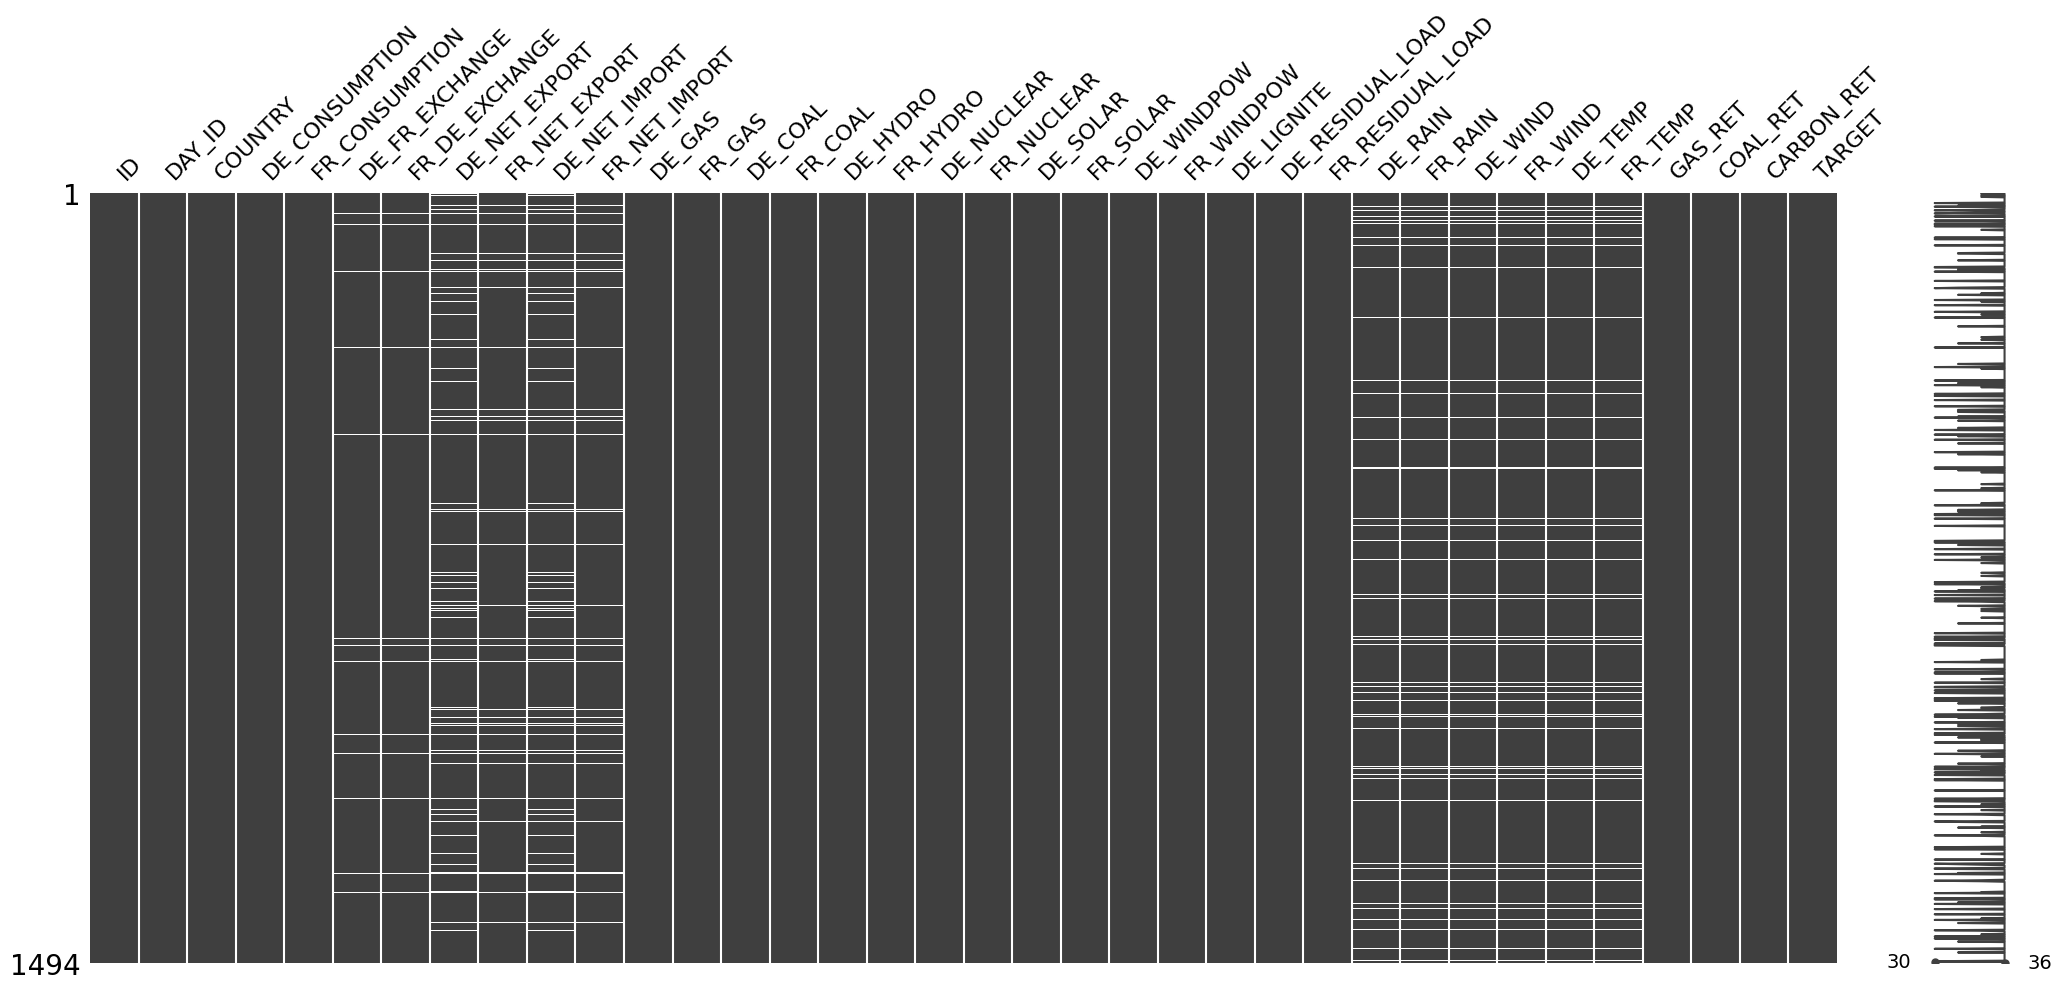

In [11]:
import missingno as msno
msno.matrix(data)

<Axes: >

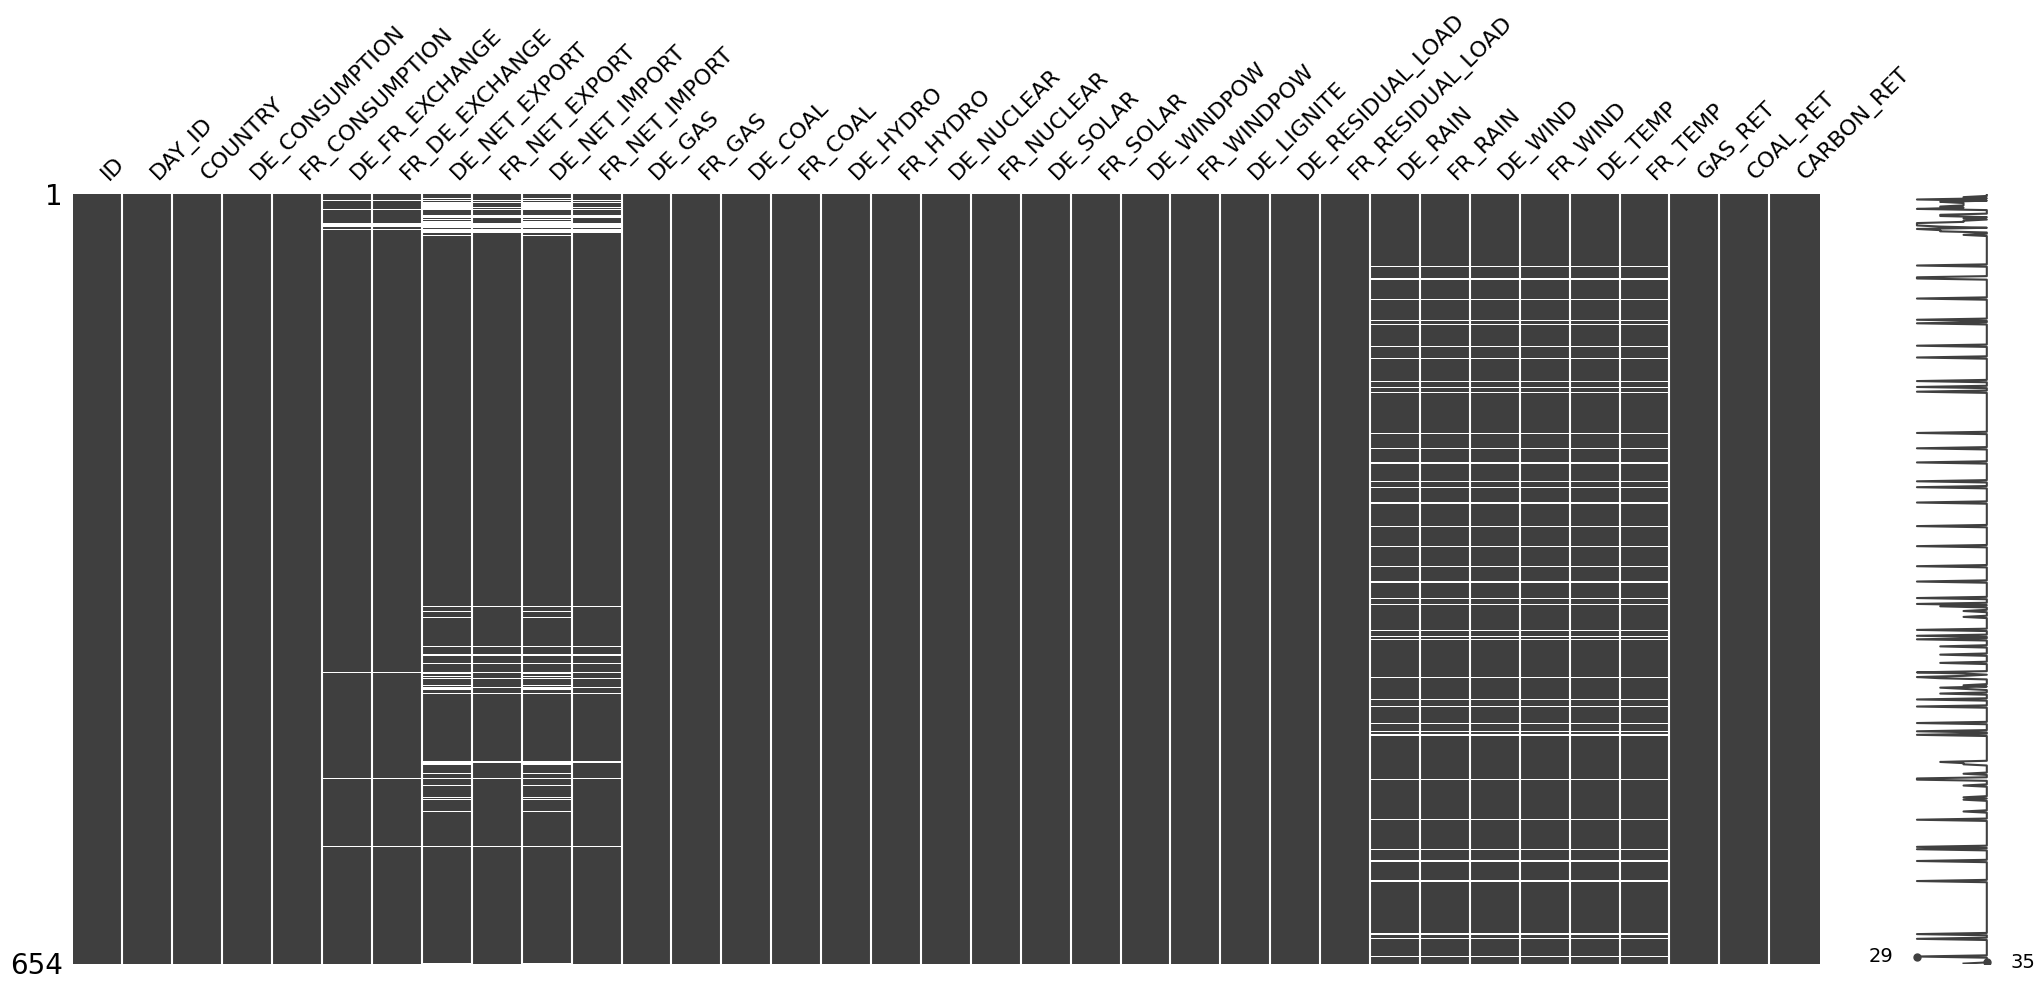

In [12]:
msno.matrix(X_test)

In [13]:
def show_missing_values(X, verbose=True):
    """Show missing values rate per columns of dataframe X

    Args:
        X (pd.DataFrame): Input data frame
    
    Return:
        missing values rate epr columns
    """
    nb_missing = X.isna().sum()
    rate_missing = nb_missing / X.ID.nunique()
    
    if verbose:
        fig, ax = plt.subplots(figsize=(4,6))
        ax1 = ax
        ax1.set_title("Missing Values Rate")
        rate_missing.plot(kind="barh", ax=ax1)
        ax1.grid()
        plt.show()
    
    return rate_missing

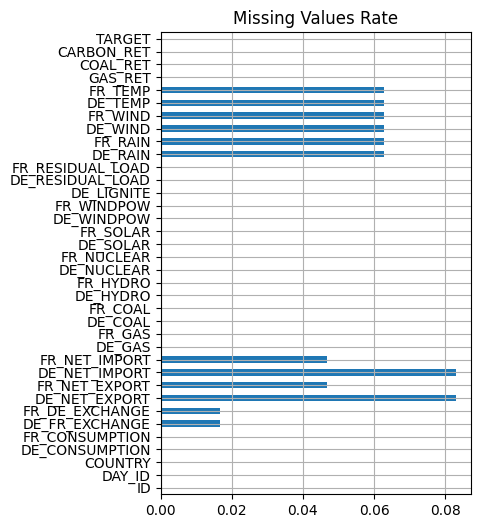

In [14]:
# Check missing values rate
rate_missing = show_missing_values(data)


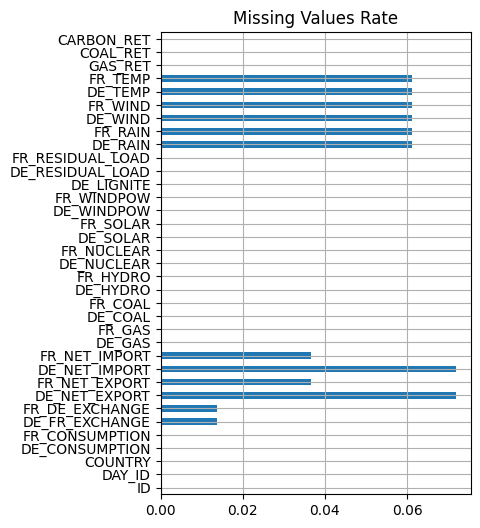

In [15]:
rate_missing_test = show_missing_values(X_test)

### Continuous or discrete

In [16]:
# Calculate the occurrences of 'DE' and 'FR' in the 'COUNTRY' column.
country_counts = data['COUNTRY'].value_counts()

country_counts['DE'], country_counts['FR']
#From the output we could see that for 208 days we have only information of FR,no DE

(643, 851)

In [17]:
def show_missing_days(X, verbose=True):
    """Get distribution of the number of points per day in dataframe X

    Args:
        X (pd.DataFrame): Input dataframe with a 'DAY_ID' column.
        verbose (bool, optional): If True, plot a figure showing the distribution. Defaults to True.

    Returns:
        pd.Series: Normalized frequency distribution of the number of points per day.
    """
    # Count the occurrences of each DAY_ID and sort by DAY_ID
    day_counts = X.DAY_ID.value_counts().sort_index()
    
    # Reindex to include all days up to the maximum DAY_ID, filling missing days with 0
    all_days = day_counts.reindex(range(1, day_counts.index.max() + 1), fill_value=0)
    
    # Count the frequency of each number of points per day
    frequency_distribution = all_days.value_counts()
    
    # Normalize the distribution
    normalized_distribution = frequency_distribution / frequency_distribution.sum()
    
    # Plot the distribution if verbose is True
    if verbose:
        fig, ax = plt.subplots(figsize=(4,1))
        ax.set_title("Number of points per day in time period")
        normalized_distribution.plot(kind="barh", ax=ax)
        ax.grid(True)
        plt.show()
    
    return normalized_distribution

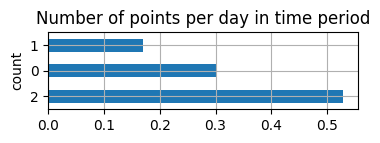

In [18]:
missing_days_distribution = show_missing_days(data)

### Split the dataset according to column names

In [19]:
# Split the dataset into data_DE and data_FR directly
train_DE = X_train[X_train['COUNTRY'] == 'DE'].drop(columns=['COUNTRY'])
train_FR = X_train[X_train['COUNTRY'] == 'FR'].drop(columns=['COUNTRY'])

In [20]:
test_DE = X_test[X_test['COUNTRY'] == 'DE'].drop(columns=['COUNTRY'])
test_FR = X_test[X_test['COUNTRY'] == 'FR'].drop(columns=['COUNTRY'])

### Fill NA with 0

In [21]:
# Fill missing values with 0.
train_DE.fillna(0, inplace=True)
train_FR.fillna(0, inplace=True)

### Data Distribution

In [22]:
def show_data_distribution(lX, 
                           labels, 
                           columns, 
                           figsize=(14, 14), 
                           nb_col=None,
                           normalize=False):
    """Show distibutions of columns of X

    Args:
        X (list): list of DataFrame
        columns (list): list of columns label we want to process
    """
    X = lX[0]
    features = [feature for feature in X.columns if feature != "COUNTRY" and feature in columns]
    if nb_col is None:
        nb_col = np.clip(len(features), 0, 6)
    nb_row = - (-len(features)//nb_col)
    if not len(labels):
        while len(labels) < len(lX):
            labels.append("X_"+str(len(labels)))
    fig, ax = plt.subplots(nb_row, nb_col, figsize=figsize)
    for i, feature in enumerate(features):
        i_col = i % nb_col
        i_row = i // nb_col
        if nb_row > 1 and nb_col > 0:
            ax1 = ax[i_row, i_col]
        elif nb_col>1:
            ax1 = ax[i_col]
        else:
            ax1 = ax

        ax1.set_title(feature)
        ax1.grid()
        for X, label in zip(lX, labels):
            X[feature].hist(bins= 30, ax=ax1, alpha=0.7, label=label, 
                            density=normalize)
        ax1.legend()

    plt.tight_layout()
    plt.show()


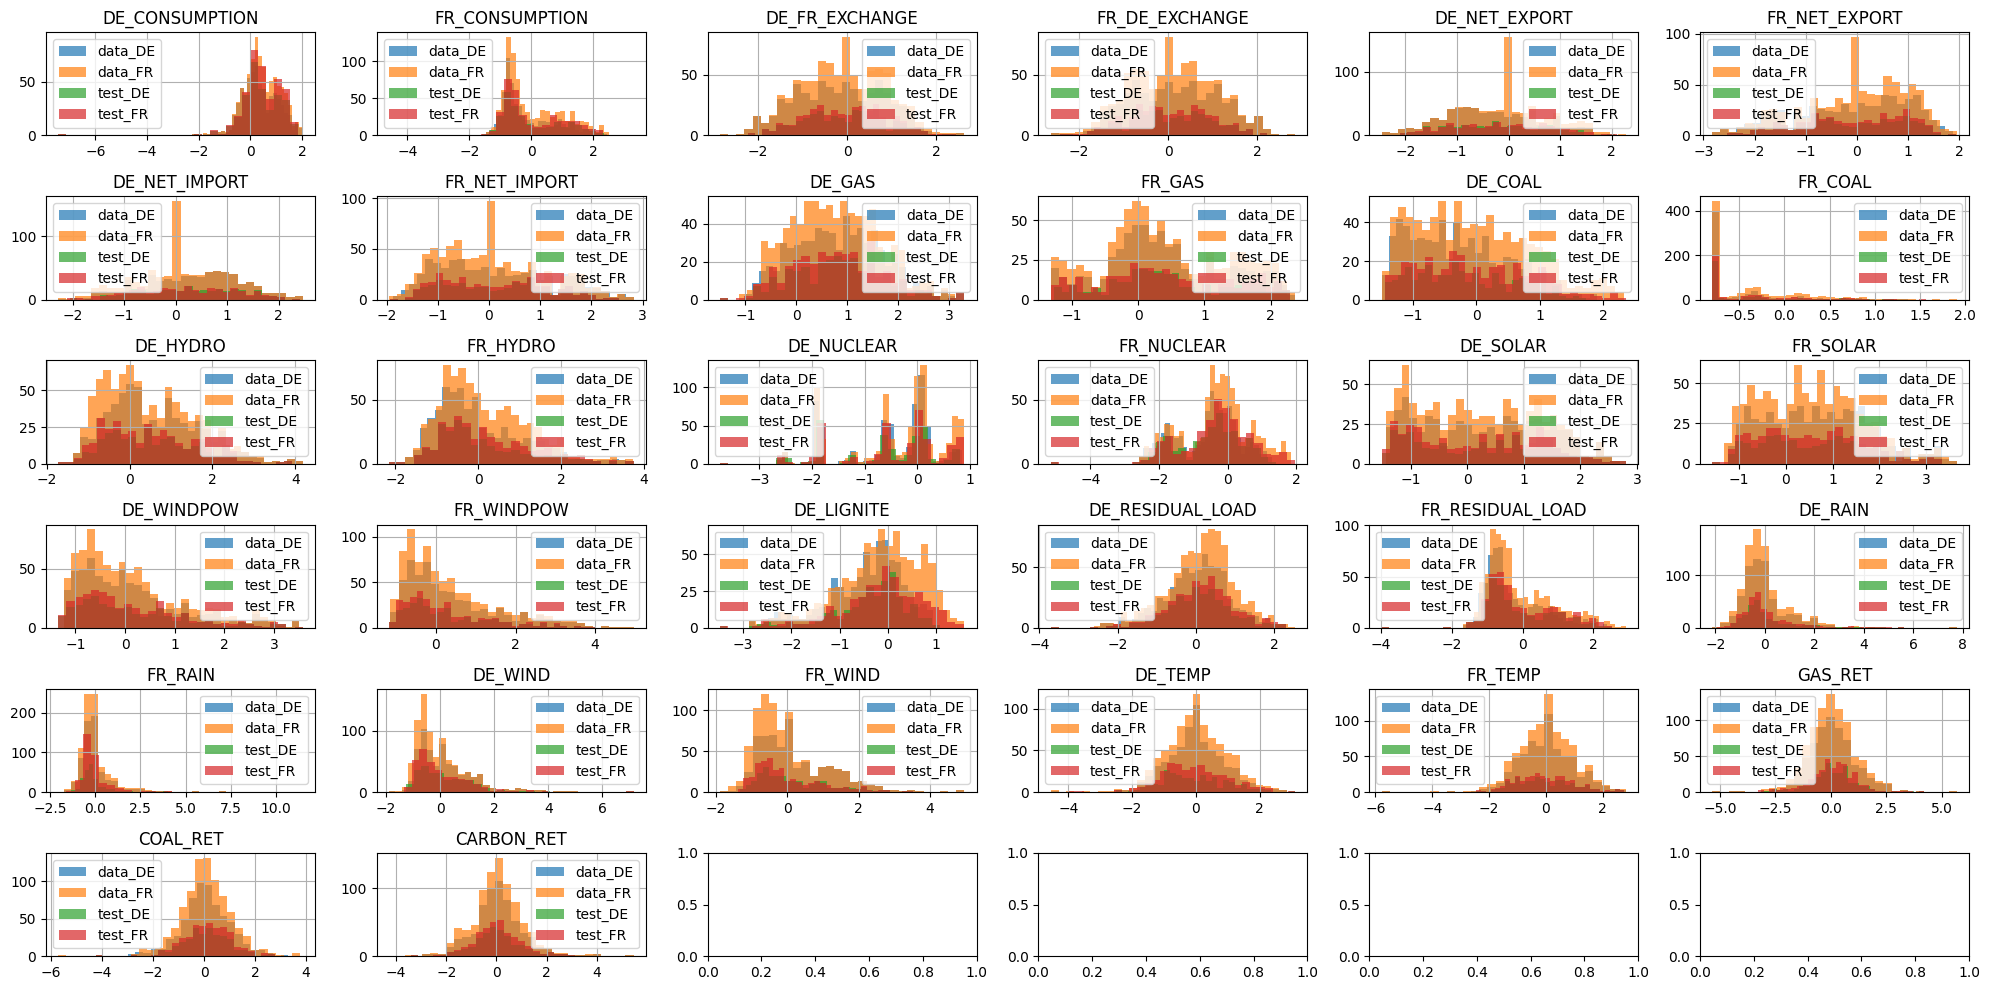

In [23]:
viz_1 = show_data_distribution([train_DE, train_FR,test_DE,test_FR], 
                           labels=["data_DE", "data_FR",'test_DE','test_FR'],
                           columns=train_DE.columns[2::],
                           normalize=False,
                           figsize=(20,10))

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize and convert back to DataFrame
train_DE_normalized = pd.DataFrame(scaler.fit_transform(train_DE), columns=train_DE.columns, index=train_DE.index)
train_FR_normalized = pd.DataFrame(scaler.fit_transform(train_FR), columns=train_FR.columns, index=train_FR.index)
test_DE_normalized = pd.DataFrame(scaler.fit_transform(test_DE), columns=test_DE.columns, index=test_DE.index)
test_FR_normalized = pd.DataFrame(scaler.fit_transform(test_FR), columns=test_FR.columns, index=test_FR.index)


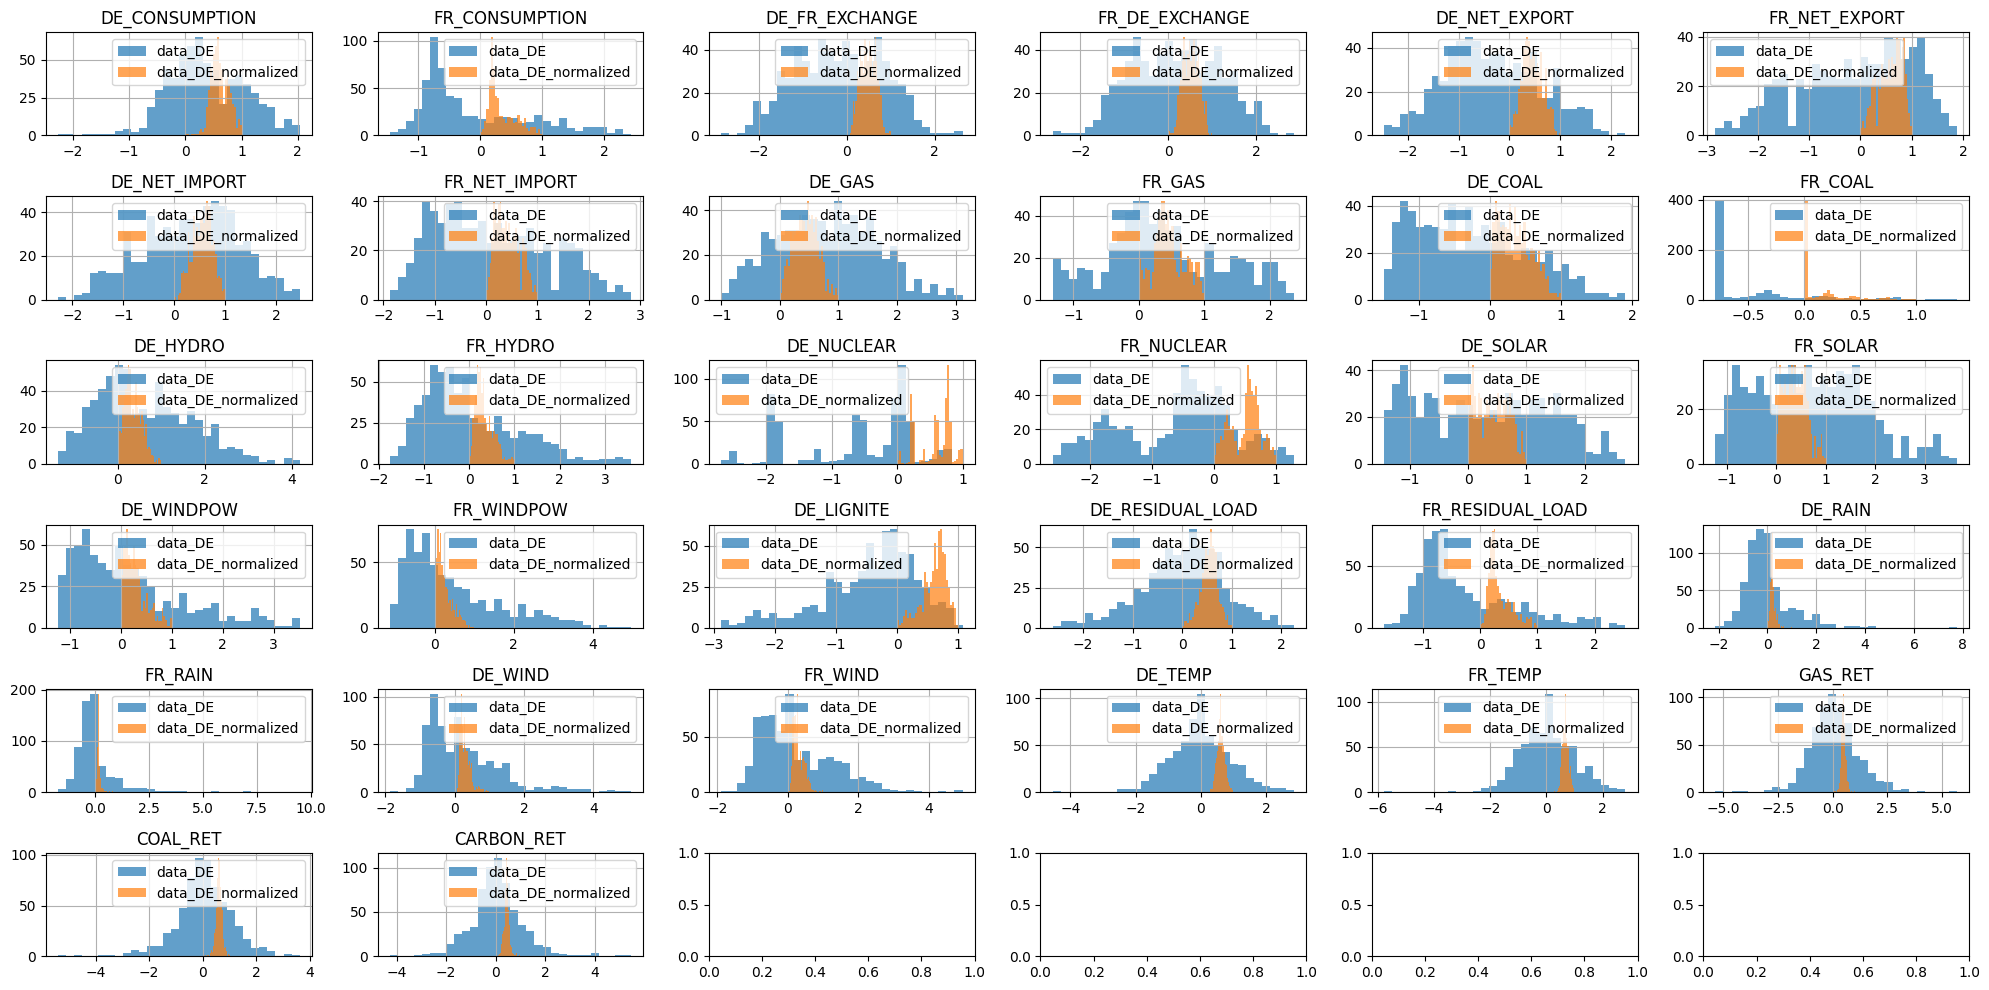

In [25]:
viz_2 = show_data_distribution([train_DE, train_DE_normalized], 
                           labels=["data_DE", "data_DE_normalized"],
                           columns=train_DE.columns[2::],
                           normalize=False,
                           figsize=(20,10))